In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
# Initialize notebook: imports and plot style config
%run init.py

Current time: 2021-02-06 07:30:14.583383


In [3]:
# source and format dataset
url = 'https://raw.githubusercontent.com/datasets/covid-19/master/data/time-series-19-covid-combined.csv'
data = pd.read_csv(url)

# rename columns
data = data.rename(columns={
    'Date': 'date',
    'Country/Region': 'location',
    'Province/State': 'region',
    'Confirmed': 'cases',
    'Recovered': 'recovered',
    'Deaths': 'deaths',
})


# dates to datetime
data['date'] = data['date'].map(lambda date: datetime.datetime.strptime(date, '%Y-%m-%d'))

# format region naming
def format_region(row):
    if row['region'] is np.nan:
        return row['location']
    else:
        return row['region']
data['region'] = data.apply(format_region, axis=1)



    
# add missing overall data for country
for country in data[data.region!=data.location].location.unique():
    if (country in data[data.location==country].region.unique())==False:
        df = data[data.location==country].groupby(['location', 'date'],as_index=False).sum()
        df['region'] = country
        data = data.append(df, ignore_index=True)
        
        

# dictionary of population
population = {
    'Hubei': 56e6,
    'Korea, South': 54.5e6,
    #'Japan': 127e6,
    #'Iran': 81e6,
    'Australia': 24.6e6,
    'US': 327e6,
    #'Switzerland': 8.5e6,
    #'Austria': 8.8e6,
    #'Germany': 82.7e6,
    #'France': 67e6,
    #'United Kingdom': 66.5e6,
    #'Spain': 46.6e6,
    #'San Marino': 33.7e3,
    #'Italy': 60e6,
    'Hong Kong': 7.392e6,
    'Canada': 37.59e6,
}
popdf = pd.read_csv('dataframes/world_population.csv')    
for state in data.region.unique():
    try: 
        data.at[data.region==state, 'population'] = popdf[popdf.location==state].population.iat[0]
    except:
        continue
for state in population.keys():
    if state not in list(popdf.location): 
        data.at[data.region==state, 'population'] = population[state]
data['population'] = data['population'].replace(np.nan, 9999999999)
data = data.replace(np.nan,0.0000000001)

# add differential columns
for col in ['cases', 'recovered', 'deaths']:
    data['new_'+col] = data[col].diff()

data['diff_new_cases'] = data['new_cases'].diff()

        
# relative increment (averaged over 1, 2, 3, 4 days)
for var in ['cases', 'deaths', 'recovered']: 
    for dayspan in [1,2,3,4]:
        colname = var+'_delta'+str(dayspan)
        data[colname] = 0
        for i in np.arange(dayspan):
            data[colname] = data[colname] + data['new_'+var].shift(i)/data[var].shift(i+1)
        data[colname] = data[colname]/dayspan
        #data[colname] = data[colname].map('{:.1e}'.format)

# add data per 100k inhabitants
for var in ['cases','new_cases','deaths','new_deaths','recovered','new_recovered']:
    data[var+'_per100k'] = data.apply(lambda row: row[var]/row.population*1e5, axis = 1)
    
# ordering and casting/formatting columns   
data = data[['date','region','cases','new_cases','diff_new_cases','deaths','new_deaths','recovered','new_recovered','population',
             'cases_per100k','new_cases_per100k','deaths_per100k','new_deaths_per100k','recovered_per100k','new_recovered_per100k',
             'cases_delta1','cases_delta2','cases_delta3','cases_delta4',
             'deaths_delta1','deaths_delta2','deaths_delta3','deaths_delta4',
             'recovered_delta1','recovered_delta2','recovered_delta3','recovered_delta4',
            ]]
data = data.replace(np.nan,0.0000000001)
data[['cases','new_cases','deaths','new_deaths','recovered','new_recovered','population']] = data[['cases','new_cases','deaths','new_deaths','recovered','new_recovered','population']].astype(int)

data['weekid'] = data['date'].map(lambda date: date.isocalendar()[1]+date.year*100)
data_weekly = data.groupby(['region','weekid'],as_index=False).sum()
data_weekly['date'] = data_weekly['weekid'].map(lambda weekid: datetime.datetime.strptime('%04d-%02d-1' % (int(weekid/100), weekid-int(weekid/100)*100), '%G-%V-%w').date()+timedelta(days=6))
data_weekly['date'] = pd.to_datetime(data_weekly['date'])
data_weekly['diff_new_cases'] = data_weekly['new_cases'].diff()

# last update time
lastday = pd.to_datetime(str(data.date.unique()[-1]))
print('\n Last updated data on:', lastday)

lastday_weekly = pd.to_datetime(str(data_weekly.date.unique()[-2]))
print('\n Last weekly updated data on:', lastday_weekly)

# print available countries
#print('\n Available Countries', data.region.unique())

data[(data.population>10e6)&(data.date==lastday)].sort_values('cases_per100k', ascending=False).head(20)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)



 Last updated data on: 2021-02-05 00:00:00

 Last weekly updated data on: 2021-02-07 00:00:00


,date,region,cases,new_cases,diff_new_cases,deaths,new_deaths,recovered,new_recovered,population,cases_per100k,new_cases_per100k,deaths_per100k,new_deaths_per100k,recovered_per100k,new_recovered_per100k,cases_delta1,cases_delta2,cases_delta3,cases_delta4,deaths_delta1,deaths_delta2,deaths_delta3,deaths_delta4,recovered_delta1,recovered_delta2,recovered_delta3,recovered_delta4,weekid
38480,2021-02-05,Czechia,1021477,8125,-1570.0,16976,150,909305,7298,10708982,9538.507021,75.870890,158.521137,1.400693,8491.049850,68.148401,0.008018,0.008839,0.008957,0.008537,0.008915,0.008743,0.008609,0.008790,8.090846e-03,8.562550e-03,8.966097e-03,9.570983e-03,202105
95249,2021-02-05,US,26808328,128114,4926.0,459403,3522,0,0,327000000,8198.265443,39.178593,140.490214,1.077064,0.000000,0.000000,0.004802,0.004720,0.004678,0.004596,0.007726,0.009502,0.009252,0.008930,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,202105
80390,2021-02-05,Portugal,755774,6916,-998.0,13740,258,585276,11342,10196707,7411.941914,67.825819,134.749385,2.530229,5739.853072,111.231989,0.009235,0.009958,0.010776,0.009989,0.019137,0.018054,0.018182,0.018732,1.976185e-02,1.943392e-02,1.973064e-02,2.301866e-02,202105
89153,2021-02-05,Spain,2941990,28565,-1395.0,61386,584,150376,0,46754783,6292.382963,61.095354,131.293519,1.249070,321.626987,0.000000,0.009805,0.010097,0.010425,0.010393,0.009605,0.008380,0.008736,0.009616,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,202105
9143,2021-02-05,Belgium,721432,2585,133.0,21295,35,0,0,11589616,6224.813661,22.304449,183.742067,0.301994,0.000000,0.000000,0.003596,0.003509,0.003800,0.003501,0.001646,0.001860,0.001917,0.002018,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,202105
74675,2021-02-05,Netherlands,997751,4321,128.0,14294,60,0,0,17134873,5822.926146,25.217578,83.420519,0.350163,0.000000,0.000000,0.004350,0.004294,0.004220,0.004072,0.004215,0.004401,0.004376,0.004761,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,202105
90677,2021-02-05,Sweden,588062,3388,-370.0,12115,87,0,0,10099270,5822.816897,33.546979,119.959165,0.861448,0.000000,0.000000,0.005795,0.006132,0.006580,0.009189,0.007233,0.007344,0.008394,0.011127,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,202105
100583,2021-02-05,United Kingdom,3911573,19114,-1520.0,111264,1014,0,0,67886004,5761.972674,28.156025,163.898290,1.493680,0.000000,0.000000,0.004911,0.005120,0.005075,0.004904,0.009197,0.008783,0.009935,0.010851,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,202105
49529,2021-02-05,France,3284085,45287,45745.0,78211,1006,206481,2836,65273512,5031.267507,69.380364,119.820426,1.541207,316.331991,4.344795,0.013983,0.006921,0.007300,0.007250,0.013030,0.006489,0.005875,0.006784,1.392620e-02,6.963098e-03,7.241837e-03,7.397790e-03,202105
11810,2021-02-05,Brazil,9447165,50872,-6001.0,230034,1239,8396148,29951,212559409,4444.482154,23.933074,108.221039,0.582896,3950.024155,14.090649,0.005414,0.005752,0.005845,0.005849,0.005415,0.005415,0.005457,0.005436,3.580002e-03,5.057372e-03,5.543476e-03,5.855900e-03,202105


In [4]:
#data.region.unique()

In [5]:
# dictionary of lockdown dates
lockdown = {
    'Italy': datetime.date(2020,3,11),
    'Hubei': datetime.date(2020,1,25),
    'Iran': datetime.date(2020,3,15),
    'Spain': datetime.date(2020,3,14),
    'United Kingdom': datetime.date(2020,3,25),
    'Austria': datetime.date(2020,3,16),
}

# dictionary of colors
color = {
    'Hubei': 'r',
    'Korea, South': 'purple',
    'Japan': 'grey',
    'Iran': 'limegreen',
    'Australia': 'royalblue',
    'US': 'hotpink',
    'Switzerland': 'brown',
    #'Austria': 'pink',
    'Germany': 'black',
    'France': 'blue',
    'United Kingdom': 'g',
    'Spain': 'orange',
    #'San Marino': 'paleturquoise',
    'Italy': 'dodgerblue',
    #'Hong Kong': 'magenta'
    'China': 'tab:red',
    'Belgium': 'mediumpurple',
    'Russia' : 'firebrick',
    'Brazil' : 'gold',
    'Sweden' : 'y',
    'Canada' : 'lightcoral',
    'India' : 'lightgreen',
    'South Africa': 'darkolivegreen',
    'Chile': 'crimson',
    'Czechia': 'crimson',
    'Netherlands': 'tab:orange',
    'Hungary': 'r'
    
}

/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


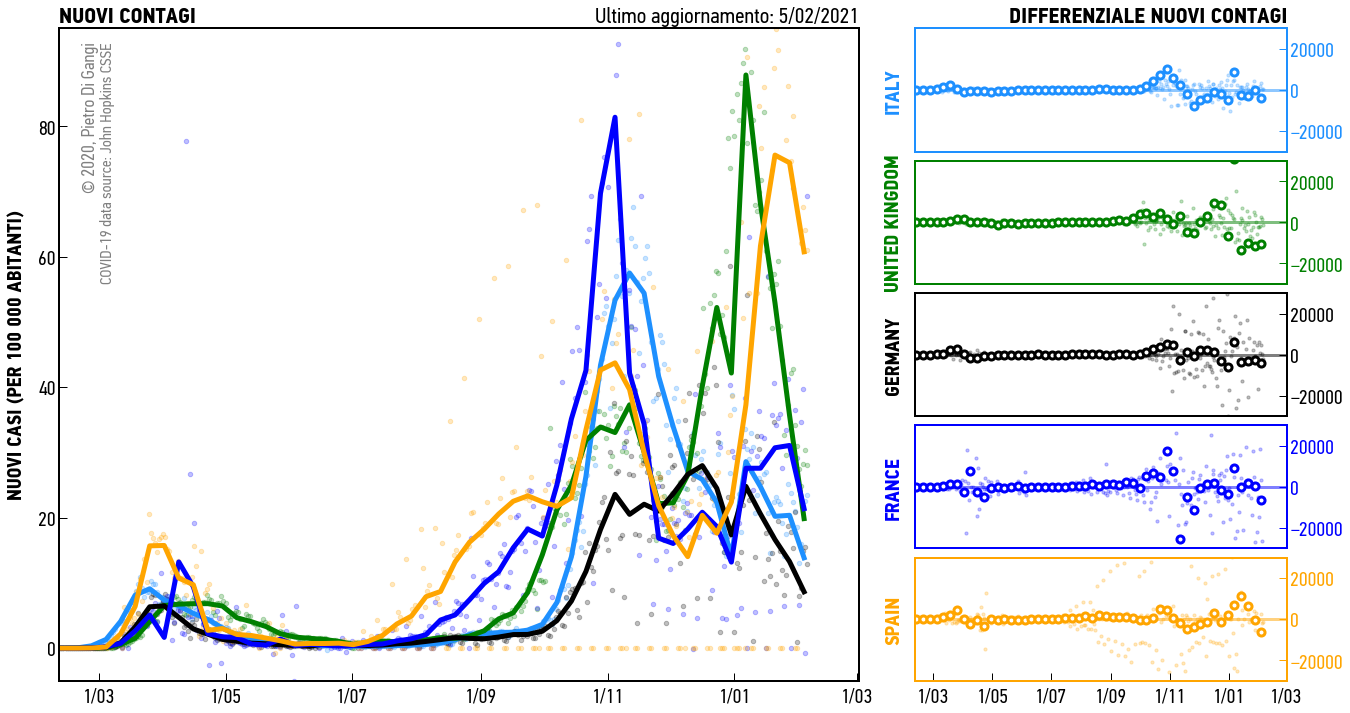

In [6]:
def color_frame(ax, color):
    [ax.spines[side].set_color(color) for side in ax.spines.keys()]

def plot_diff_new_cases():
    
    def scatter_daily(ax, var, color):
        ax.scatter(dates_daily[2:], df_[var][2:], color=color, alpha=0.25, s=10)

    def weekly_avg(ax, var, color):
        ax.scatter(dates_weekly[1:-1]-timedelta(days=3, hours=12), df[var][1:-1]/7, 
                   edgecolor=color, color='w', linestyle='-', linewidth=3, marker='o', s=50)

    def set_yaxis(ax, label, color):
        ax.set_ylabel(label, color=color)
        ax.tick_params(axis='y', colors=color)

    #legend
    def build_legend(ax, color, var, label1):
        lb1 = '%s: %+d' % (label1, df_[var].iat[-1])
        lb2 = 'Media settimanale: %+.0f' % (df[var].iat[-2]/7)
        diff1 = (df[var].iat[-2] - df[var].iat[-3])/df[var].iat[-3]*100
        diff2 = (df[var].iat[-3] - df[var].iat[-4])/df[var].iat[-4]*100
        diff3 = (df[var].iat[-4] - df[var].iat[-5])/df[var].iat[-5]*100
        lb3 = 'Variazione relativa su base settimanale:'
        lb4 = '%+.0f%s (ultima settimana)' % (diff1, '%')
        lb5 = '%+.0f%s (2 settimane fa)' % (diff2, '%')
        lb6 = '%+.0f%s (3 settimane fa)' % (diff3, '%')
        legend_elements = [
            Line2D([0], [0], marker='.', markersize=6, color=color, linestyle='None', label=lb1, alpha=0.5),
            Line2D([0], [0], marker='o', markersize=10, markeredgecolor=color, color='w', markeredgewidth=3.5, linewidth=0, label=lb2),
            Line2D([0], [0], markersize=0, color=color, linestyle='None', label=lb3),
            Line2D([0], [0], markersize=0, color=color, linestyle='None', label=lb4),
            Line2D([0], [0], markersize=0, color='k', linestyle='None', label=lb5),
            Line2D([0], [0], markersize=0, color='k', linestyle='None', label=lb6),
          ]
        leg = ax.legend(handles=legend_elements, loc='upper center', frameon=False)
        for h, t in zip(leg.legendHandles[2:], leg.get_texts()[2:]):
            t.set_color(h.get_color())
    
    
    fig = plt.figure(figsize=(22,12))
    grid = plt.GridSpec(5, 3, hspace=0.075, wspace=0.15)
    ax_main = fig.add_subplot(grid[0:, 0:2])
    ax1 = fig.add_subplot(grid[0, 2:])
    ax2 = fig.add_subplot(grid[1, 2:], sharex=ax1)
    ax3 = fig.add_subplot(grid[2, 2:], sharex=ax1)
    ax4 = fig.add_subplot(grid[3, 2:], sharex=ax1)
    ax5 = fig.add_subplot(grid[4:, 2:], sharex=ax1)
    ax1.tick_params(labelbottom=False, bottom='off', labelleft=False, labelright=True, left='off', right='on') 
    ax2.tick_params(labelbottom=False, bottom='off', labelleft=False, labelright=True, left='off', right='on')
    ax3.tick_params(labelbottom=False, bottom='off', labelleft=False, labelright=True, left='off', right='on')
    ax4.tick_params(labelbottom=False, bottom='off', labelleft=False, labelright=True, left='off', right='on')
    ax5.tick_params(labelleft=False, labelright=True, left='off', right='on')


    var1 = 'diff_new_cases'
    color1 = 'tab:blue'
    axes = [ax1, ax2, ax3, ax4, ax5]

    states = ['Italy', 'United Kingdom', 'Germany', 'France', 'Spain']
    
    for i, region in enumerate(states):
        ax = axes[i]
        df_ = data[data.region==region]
        df = data_weekly[data_weekly.region==region]
        dates_daily = df_.date
        dates_weekly = pd.to_datetime(df.date)

        #ax1.plot(dates_weekly[1:-1]-timedelta(days=3, hours=12), df[var1][1:-1]/7, 
        #           color=color[region], linestyle='-', linewidth=8, alpha=0.25)
        scatter_daily(ax, var1, color[region])
        weekly_avg(ax, var1, color[region])
        color_frame(ax, color[region])
        
        #print(region, df_[var1])

        #ax1.set_xlim(datetime.date(2020,7,1), lastday+timedelta(days=25))
        ax.set_xlim(dates_daily.iat[20], lastday+timedelta(days=25))
        #ax3.set_xlim(dates_daily.iat[2], lastday+timedelta(days=25))
        ax.set_ylim(-30000,30000)
        ax.hlines(0, ax.get_xlim()[0], ax.get_xlim()[1], color[region], alpha=0.5, linestyle='-', zorder=-500)
        set_yaxis(ax, region.upper(), color[region])
        
        
        ax_main.scatter(dates_daily[2:], df_['new_cases_per100k'][2:], color=color[region], alpha=0.25, s=20)
        ax_main.plot(dates_weekly[1:-1]-timedelta(days=3, hours=12), df['new_cases_per100k'][1:-1]/7, 
                   color=color[region], lw=5, linestyle='-')
        #ax_main.scatter(dates_weekly[1:-1]-timedelta(days=3, hours=12), df['new_cases'][1:-1]/7, 
        #           edgecolor=color[region], color='w', linestyle='-', linewidth=4, marker='o', s=100)
        
    #set_yaxis(ax2, 'RICOVERI OSPEDALIERI', color2)
    #set_yaxis(ax3, 'TERAPIE INTENSIVE', color3)

    
    #ax3.hlines(0, ax3.get_xlim()[0], ax3.get_xlim()[1], 'grey', alpha=0.5, zorder=-500)

    ax_main.set_xlim(dates_daily.iat[20], lastday+timedelta(days=25))
    ax_main.set_ylim(-5, 95)
    set_yaxis(ax_main, 'NUOVI CASI (PER 100 000 ABITANTI)', 'k')
    
    ax5.xaxis.set_major_formatter(mdates.DateFormatter('%-d/%m'))
    ax_main.xaxis.set_major_formatter(mdates.DateFormatter('%-d/%m'))
    #fig.autofmt_xdate()
    #plt.gcf().autofmt_xdate()


    #for axx in [ax1]: #,ax2,ax3]:
        #axx.autoscale(False)
        #alpha=0.75
        #axx.vlines(datetime.datetime(2020,3,11),-1e6,1e6, color='grey', linestyles='--', linewidth=1, alpha=alpha, zorder=-100)
        #axx.vlines(phase2_date,-1e6,1e6, color='grey', linestyles='--', linewidth=1, alpha=alpha, zorder=-100)
        #axx.vlines(datetime.datetime(2020,10,26),-1e6,1e6, color='grey', linestyles='--', linewidth=1, alpha=alpha, zorder=-100)
        #axx.vlines(datetime.datetime(2020,11,6),-1e6,1e6, color='grey', linestyles='--', linewidth=1, alpha=alpha, zorder=-100)

    #ymax = ax1.get_ylim()[1]
    #xoffset = timedelta(days=1)
    #txtargs={'color':'grey', 'fontsize':16, 'rotation':90, 'va':'top', 'ha':'right', 'alpha':0.75}
    #ax1.text(datetime.datetime(2020,3,11)-xoffset, ymax*0.99, 'Lockdown', **txtargs)
    #ax1.text(phase2_date-xoffset, ymax*0.99, 'Fase 2', **txtargs)
    #txtargs={'color':'grey', 'fontsize':16, 'rotation':90, 'va':'bottom', 'ha':'left', 'alpha':0.75}
    #ax1.text(datetime.datetime(2020,10,26)+xoffset, ymax*0.03, 'Lockdown serale', **txtargs)
    #ax1.text(datetime.datetime(2020,11,6)+xoffset, ymax*0.03, 'Lockdown regionali', **txtargs)

    #build_legend(ax1, color1, var1, 'Nuovi casi giornalieri')
    #build_legend(ax2, color2, var2, 'Variazione giornaliera')
    #build_legend(ax3, color3, var3, 'Variazione giornaliera')

    # disclaimer
    day0 = dates_daily.iat[20]
    dayspan = dates_daily.iat[-1] - day0
    text = '© 2020, Pietro Di Gangi'
    ax_main.text(day0+0.03*dayspan, 93, text, rotation=90, verticalalignment='top', color='grey', fontsize=18)
    text = 'COVID-19 data source: John Hopkins CSSE'
    ax_main.text(day0+0.055*dayspan, 93, text, rotation=90, verticalalignment='top', color='grey', fontsize=16)

    ax_main.set_title('Ultimo aggiornamento: %s' % (dates_daily.iat[-1].strftime('%-d/%m/%Y')), fontweight='100', loc='right')
    ax1.set_title('DIFFERENZIALE NUOVI CONTAGI', fontweight='900', loc='right')
    ax_main.set_title('NUOVI CONTAGI', fontweight='900', loc='left')

    plt.show()
    
plot_diff_new_cases()

In [7]:
data_weekly[data_weekly['region']=='Spain']

,region,weekid,cases,new_cases,diff_new_cases,deaths,new_deaths,recovered,new_recovered,population,cases_per100k,new_cases_per100k,deaths_per100k,new_deaths_per100k,recovered_per100k,new_recovered_per100k,cases_delta1,cases_delta2,cases_delta3,cases_delta4,deaths_delta1,deaths_delta2,deaths_delta3,deaths_delta4,recovered_delta1,recovered_delta2,recovered_delta3,recovered_delta4,date
13048,Spain,202004,0,-4355,-4355.0,0,-66,0,-3663,233773915,0.000000,-9.314555,0.000000,-0.141162,0.000000,-7.834493,-1.000000,-0.489688,-2.977832e-01,-2.233374e-01,-1.000000e+00,-5.000000e-01,-3.229167e-01,-2.421875e-01,-1.000000e+00,-4.960099e-01,-3.287358e-01,-2.465519e-01,2020-01-26
13049,Spain,202005,2,1,4356.0,0,0,0,0,327283481,0.004278,0.002139,0.000000,0.000000,0.000000,0.000000,inf,inf,7.000000e-10,7.000000e-10,7.000000e-10,7.000000e-10,7.000000e-10,7.000000e-10,7.000000e-10,7.000000e-10,7.000000e-10,7.000000e-10,2020-02-02
13050,Spain,202006,8,1,0.0,0,0,0,0,327283481,0.017111,0.002139,0.000000,0.000000,0.000000,0.000000,1.000000,0.500000,inf,inf,7.000000e-10,7.000000e-10,7.000000e-10,7.000000e-10,7.000000e-10,7.000000e-10,7.000000e-10,7.000000e-10,2020-02-09
13051,Spain,202007,14,0,-1.0,0,0,4,2,327283481,0.029943,0.000000,0.000000,0.000000,0.008555,0.004278,0.000000,0.500000,6.666667e-01,7.500000e-01,7.000000e-10,7.000000e-10,7.000000e-10,7.000000e-10,inf,inf,7.000000e-10,7.000000e-10,2020-02-16
13052,Spain,202008,14,0,0.0,0,0,14,0,327283481,0.029943,0.000000,0.000000,0.000000,0.029943,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,7.000000e-10,7.000000e-10,7.000000e-10,7.000000e-10,0.000000e+00,0.000000e+00,inf,inf,2020-02-23
13053,Spain,202009,197,82,82.0,0,0,14,0,327283481,0.421347,0.175383,0.000000,0.000000,0.029943,0.000000,5.726763,5.293429,5.013568e+00,4.590304e+00,7.000000e-10,7.000000e-10,7.000000e-10,7.000000e-10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2020-03-01
13054,Spain,202010,2339,589,507.0,38,17,70,28,327283481,5.002697,1.259764,0.081275,0.036360,0.149717,0.059887,2.456094,2.716428,2.855289e+00,3.071952e+00,inf,inf,inf,inf,1.400000e+01,1.400000e+01,9.333333e+00,7.000000e+00,2020-03-08
13055,Spain,202011,26743,7125,6536.0,789,272,1657,487,327283481,57.198426,15.239083,1.687528,0.581759,3.544022,1.041605,3.256835,3.319758,3.350225e+00,3.177119e+00,3.824833e+00,3.933807e+00,4.148077e+00,4.067333e+00,6.518818e+00,6.518818e+00,1.062590e+01,1.266578e+01,2020-03-15
13056,Spain,202012,128115,20970,13845.0,6518,1483,10034,2058,327283481,274.014746,44.851026,13.940820,3.171868,21.460906,4.401689,1.445198,1.488395,1.495563e+00,1.789531e+00,2.106656e+00,2.203318e+00,2.284823e+00,2.615964e+00,2.024810e+00,1.918927e+00,2.330498e+00,2.441318e+00,2020-03-22
13057,Spain,202013,401386,51342,30372.0,31054,5031,55102,12134,327283481,858.491847,109.811225,66.418873,10.760396,117.853183,25.952425,1.110526,1.130468,1.180064e+00,1.204598e+00,1.493500e+00,1.569241e+00,1.645837e+00,1.704018e+00,2.039152e+00,2.046378e+00,2.057200e+00,2.087774e+00,2020-03-29


In [8]:
# Utility functions

def rate(df, var, dayspan=3):
    k=[]
    for i in np.arange(dayspan):
        k.append(df['new_'+var].iat[-1-i]/df[var].iat[-1-i])
    return np.mean(k)*100

def format_dateaxis():
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    fig.autofmt_xdate()
    plt.gcf().autofmt_xdate()

def lockdown_lines():
    for state in lockdown.keys():
        ax.vlines(lockdown[state],-1000,1000, color=color[state], linestyle='--', linewidth=2, alpha=0.75)

def sorted_states(states, var):
    df = data[data.region.isin(states)][data.date==lastday].sort_values(var, ascending=False)
    states = df.region.unique()
    return states

def sorted_states_weekly(states, var):
    df = data_weekly[data_weekly.region.isin(states)][data_weekly.date==lastday_weekly].sort_values(var, ascending=False)
    states = df.region.unique()
    return states

def leglabels_style():
    leg._legend_box.align = "left"
    for line, text in zip(leg.get_lines(), leg.get_texts()):
        text.set_color(line.get_color())

def plot_total(var,lw=3):
    #cmap = plt.get_cmap('tab20')
    for state in states:
        df = data[data.region==state]
        pop = df.population.iat[0]
        tot = df[var].iat[-1] # total value at current date
        new = df['new_'+var].iat[-1]
        k = rate(df, var)
        label = state + '\nTotal: %.f (+%.f)\n1 over %.f\nDaily increase: +%.1f%s' % (tot, new, pop/tot, k, '%')
        if var=='deaths': 
            mortality = tot/df['cases'].iat[-1]*100
            label = label + '\nMortality: %.1f%s' % (mortality, '%')
        ax.plot(df.date, df[var]/pop*1e5, label=label, color=color[state], lw=lw)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


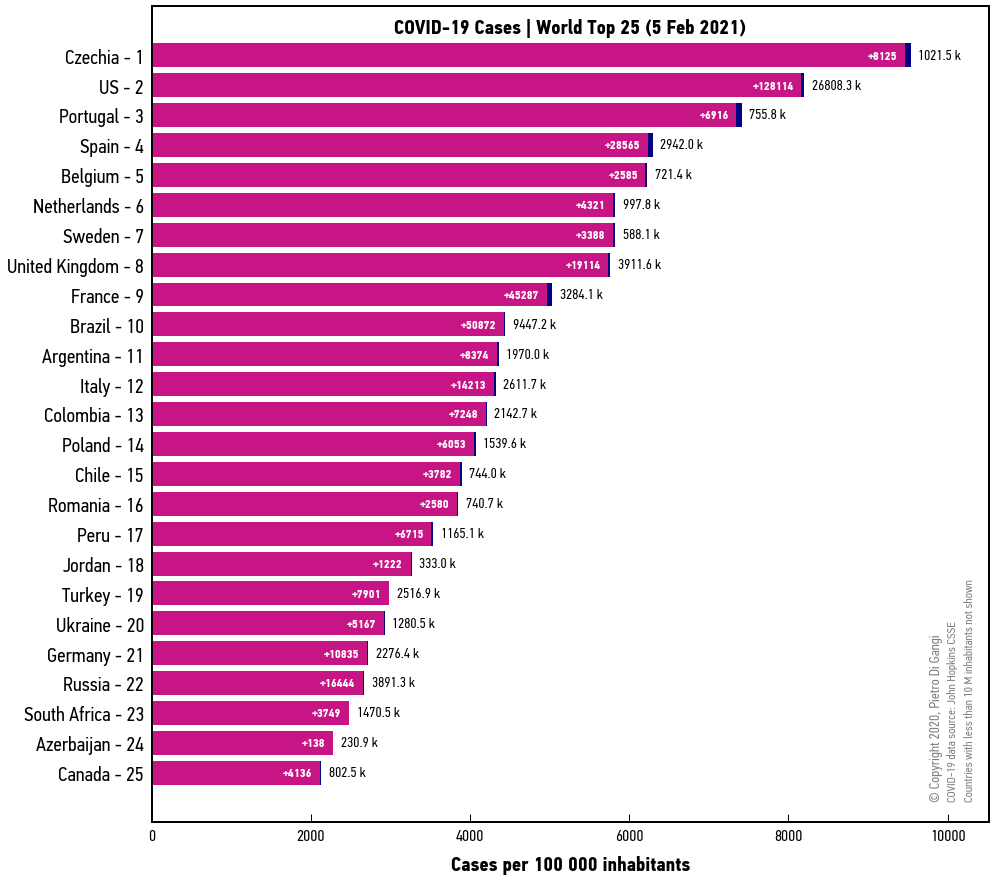

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


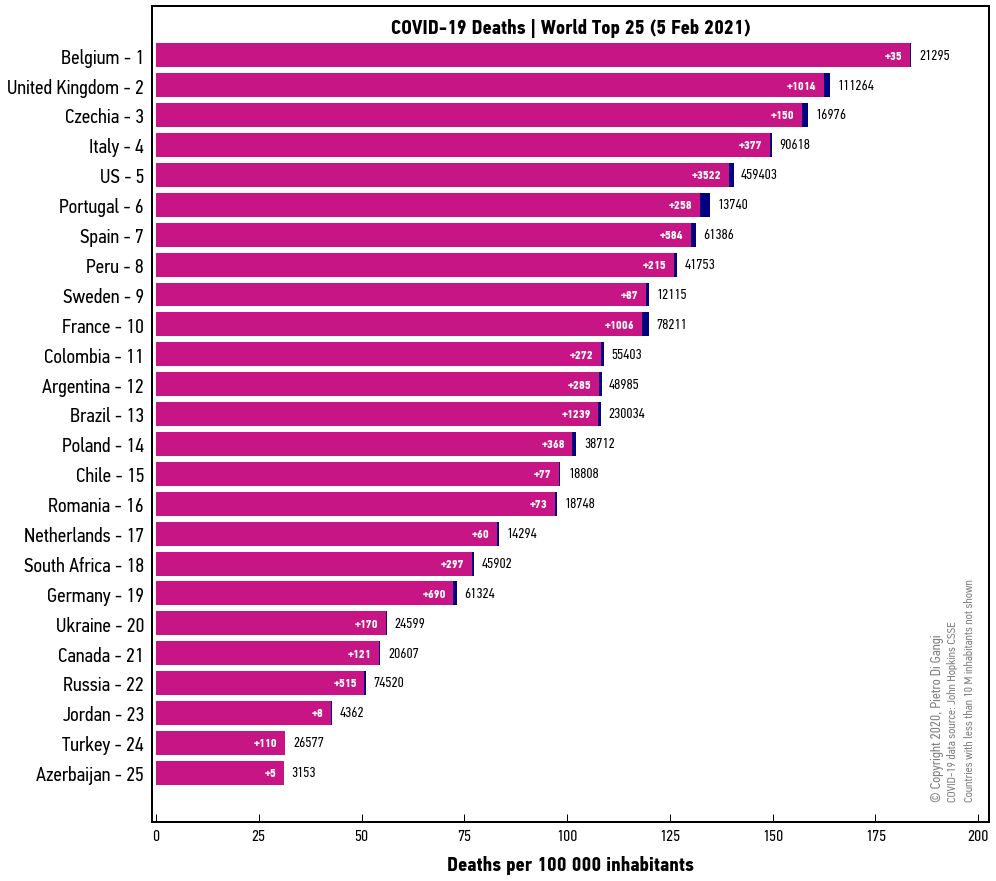

In [9]:
def standing_normalized(states, var, title='', xlabel='x', xmax=100):

    n = len(states)*0.1
    
    fig = plt.figure(figsize=(15,6*n))
    ax = fig.add_subplot(111)
    ax.tick_params(left=False) 
    states = sorted_states(states, var+'_per100k')   
    totmax = data[data.region==states[0]][var+'_per100k'].iat[-1]   
    states = states[::-1]
    
    for i,state in enumerate(states):
        df = data[data.region==state]
        pop = data.population.iat[0]
        tot = df[var].iat[-1]
        ylab = state+' - %d ' % -(i-len(states))
        ax.barh(ylab, df[var+'_per100k'].iat[-1], color='navy', label='', alpha=0.99)
        for days in np.arange(1):
            ax.barh(ylab, df[var+'_per100k'].iat[-2-days], color='mediumvioletred', label='', alpha=1)
        lb = '%.1f k' % (tot/1000)
        if var=='deaths': lb = '%d' % (tot)
        ax.text(df[var+'_per100k'].iat[-1]+0.01*totmax, ylab, lb, ha='left', va='center', fontsize=14)
        ax.text(df[var+'_per100k'].iat[-2]-0.01*totmax, ylab, ('+%d' % df['new_'+var].iat[-1]), ha='right', va='center', color='w', fontsize=12, weight='bold')
    
    plt.xlabel(xlabel)
    ax.tick_params(axis='x', which='major', labelsize=16)
    xmax = ax.get_xlim()[1]*1.05
    ax.set_xlim(-1,xmax)
    
    #legend
    plt.title(title+' (%s)' % lastday.strftime('%-d %b %Y'), fontsize=20, y=0.96)
    
    # disclaimer
    text = '© Copyright 2020, Pietro Di Gangi'
    plt.text(xmax-0.07*xmax, -0.95, text, rotation=90, verticalalignment='bottom', color='grey', fontsize=14, backgroundcolor='w')
    text = 'COVID-19 data source: John Hopkins CSSE'
    plt.text(xmax-0.05*xmax, -0.95, text, rotation=90, verticalalignment='bottom', color='grey', fontsize=12, backgroundcolor='w')
    text = 'Countries with less than 10 M inhabitants not shown'
    plt.text(xmax-0.03*xmax, -0.95, text, rotation=90, verticalalignment='bottom', color='grey', fontsize=12, backgroundcolor='w')

    plt.show()
    
    #fig.savefig('figure/%s-covid19-sicilia-contagi-normalizzati.png' % lastday.strftime('%Y-%m-%d'))
       
    
states = data[(data.population>10e6)&(data.date==lastday)].sort_values('cases_per100k', ascending=False).head(25).region.unique()
standing_normalized(states, 'cases', 'COVID-19 Cases | World Top 25', 'Cases per 100 000 inhabitants')

states = data[(data.deaths>100)&(data.population>10e6)&(data.date==lastday)].sort_values('cases_per100k', ascending=False).head(25).region.unique()
standing_normalized(states, 'deaths', 'COVID-19 Deaths | World Top 25', 'Deaths per 100 000 inhabitants')

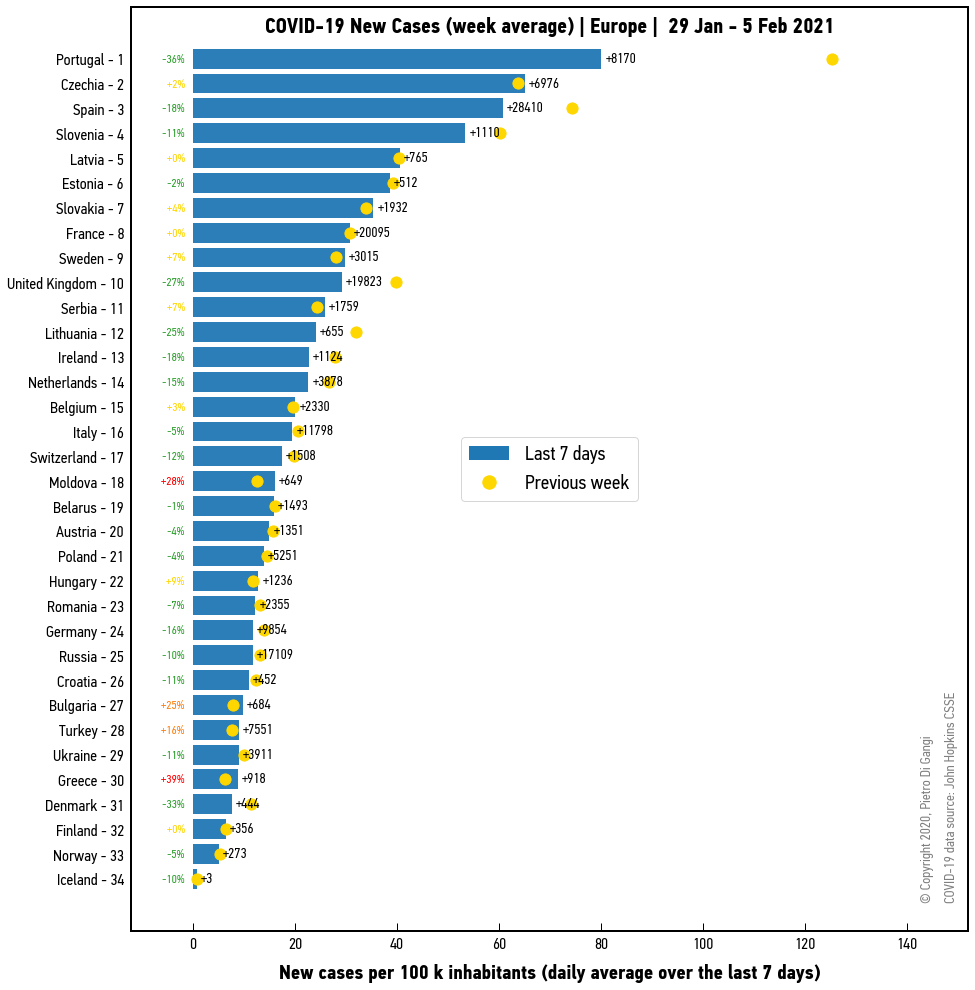

In [10]:
eu = ['Sweden',
      'Russia',
      'Italy', 
      'Spain', 
      'United Kingdom', 
      'Germany', 
      'France', 
      'Netherlands',
      'Belgium',
      'Greece',
      'Serbia',
      'Norway',
      'Austria',
      'Switzerland',
      'Portugal',
      'Ireland',
      'Finland',
      'Slovenia',
      'Ukraine',
      'Poland',
      'Romania',
      'Belarus',
      'Bulgaria',
      'Hungary',
      'Denmark',
      'Turkey',
      'Slovakia',
      'Estonia',
      'Croatia',
      'Latvia',
      'Lithuania',
      'Czechia',
      'Iceland',
      'Moldova',
     ]

from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib
import matplotlib.cm as cm
def standing_lastweek(states, title='', color='mediumvioletred', zone='World'):
    
    # dataframe
    df_week = pd.DataFrame(columns=['cases_per100k', 'cases_per100k_prev', 'cases', 'cases_prev', 'population'])
    for state in states:
        df = data[data.region==state]
        pop = df.population.iat[0]
        cases = 0
        cases_prev = 0
        for i in np.arange(-7,0):
            cases = cases + df['new_cases'].iat[i]
        for i in np.arange(-14,-7):
            cases_prev = cases_prev + df['new_cases'].iat[i]
        df_week.loc[state] = pd.Series({'cases_per100k':cases/pop*1e5, 'cases_per100k_prev':cases_prev/pop*1e5, 'cases':cases,  'cases_prev':cases_prev, 'population':pop})

    df_week = df_week.sort_values('cases_per100k', ascending=False)

    # plot
    #data = df_week
    n = len(states)*0.1
    fig = plt.figure(figsize=(15,5*n))
    ax = fig.add_subplot(111)
    ax.tick_params(left=False) 
    totmax = df_week['cases_per100k'].iat[0]/7  
    states = df_week.index
    states = states[::-1]
    
    # set a color map
    df_week['var'] = (df_week['cases']-df_week['cases_prev'])/df_week['cases_prev']
    minimum = -1 #min(df_week['var'])
    maximum = 1 #max(df_week['var'])
    norm = matplotlib.colors.Normalize(vmin=minimum, vmax=maximum, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.RdYlGn_r)


    for i,state in enumerate(states):
        df = df_week[df_week.index==state]
        #pop = data.population.iat[0]
        #tot = df[var].iat[-1]
        ylab = state+' - %d ' % -(i-len(states))
        ax.barh(ylab, df['cases_per100k']/7, color=color, label='', height=0.8, alpha=0.95)
        
        ax.scatter(df['cases_per100k_prev']/7, ylab, color='gold', marker='.', s=500, label='', alpha=1, zorder=100)
        
        lb = '%+.0f' % (df['cases']/7)
        ax.text(df['cases_per100k']/7 + 0.01*totmax, ylab, lb, ha='left', va='center', fontsize=14, zorder=200)
        
        
        var = ((df['cases']-df['cases_prev'])/df['cases_prev'])[0]
        if var<=0:
            col = 'tab:green'
        elif (var>0) & (var<=0.10):
            col = 'gold'
        elif (var>0.10) & (var<=0.25):
            col = 'tab:orange'
        elif (var>0.25) & (var<=0.50):
            col = 'red'
        elif (var>0.50) & (var<=1.):
            col = 'darkred'
        else: col = 'black'
        lb = '  %+.0f%s' % ( var*100, '%' )
        ax.text(-0.02*totmax, ylab, lb, color=col, ha='right', va='center', fontsize=12, alpha=1, zorder=200)

    '''
    if zone=='Europe':
        plt.axvline(45/7,-1,0.95, color='black', ls='-', alpha=0.2, zorder=-200)
        ax.text(45/7-0.015*totmax, -1, 'GER (April)', va='bottom', ha='center', rotation=90, fontsize=12, color='black', alpha=0.75)
        plt.axvline(48/7,-1,0.95, color='tab:green', ls='-', alpha=0.2, zorder=-200)
        ax.text(48/7+0.02*totmax, -1, 'UK (May)', va='bottom', ha='center', rotation=90, fontsize=12, color='tab:green', alpha=0.75)
        plt.axvline(65/7,-1,0.95, color='dodgerblue', ls='-', alpha=0.2, zorder=-200)
        ax.text(65/7+0.02*totmax, -1, 'ITA (March)', va='bottom', ha='center', rotation=90, fontsize=12, color='dodgerblue', alpha=0.75)
        plt.axvline(75/7,-1,0.95, color='blue', ls='-', alpha=0.2, zorder=-200)
        ax.text(75/7+0.02*totmax, -1, 'FRA (April)', va='bottom', ha='center', rotation=90, fontsize=12, color='blue', alpha=0.75)
        plt.axvline(85/7,-1,0.95, color='mediumpurple', ls='-', alpha=0.2, zorder=-200)
        ax.text(85/7+0.02*totmax, -1, 'BEL (April)', va='bottom', ha='center', rotation=90, fontsize=12, color='mediumpurple', alpha=0.75)
        plt.axvline(110/7,-1,0.95, color='tab:orange', ls='-', alpha=0.2, zorder=-200)
        ax.text(110/7+0.02*totmax, -1, 'ESP (March)', va='bottom', ha='center', rotation=90, fontsize=12, color='tab:orange', alpha=0.75)
    elif zone=='World':
        plt.axvline(48/7,-1,0.95, color='tab:green', ls='-', alpha=0.2, zorder=-200)
        ax.text(48/7+0.02*totmax, -1, 'UK (May)', va='bottom', ha='center', rotation=90, fontsize=12, color='tab:green', alpha=0.75)
        plt.axvline(65/7,-1,0.95, color='dodgerblue', ls='-', alpha=0.2, zorder=-200)
        plt.axvline(65/7,-1,0.95, color='dodgerblue', ls='-', alpha=0.2, zorder=-200)
        ax.text(65/7+0.02*totmax, -1, 'ITA (March)', va='bottom', ha='center', rotation=90, fontsize=12, color='dodgerblue', alpha=0.75)
        plt.axvline(110/7,-1,0.95, color='tab:orange', ls='-', alpha=0.2, zorder=-200)
        ax.text(110/7+0.02*totmax, -1, 'ESP (March)', va='bottom', ha='center', rotation=90, fontsize=12, color='tab:orange', alpha=0.75)
        plt.axvline(150/7,-1,0.95, color='hotpink', ls='-', alpha=0.2, zorder=-200)
        ax.text(150/7+0.02*totmax, -1, 'USA (July)', va='bottom', ha='center', rotation=90, fontsize=12, color='hotpink', alpha=0.75)
        plt.axvline(220/7,-1,0.95, color='darkred', ls='-', alpha=0.2, zorder=-200)
        ax.text(220/7+0.02*totmax, -1, 'CHI (June)', va='bottom', ha='center', rotation=90, fontsize=12, color='darkred', alpha=0.75)
    '''
        
    # labels and axes limits
    plt.xlabel('New cases per 100 k inhabitants (daily average over the last 7 days)')
    ax.tick_params(axis='x', which='major', labelsize=16)
    ax.tick_params(axis='y', which='major', labelsize=16)
    xmax = ax.get_xlim()[1]*1.15
    ax.set_xlim(-0.08*xmax,xmax)

    #legend
    legend_elements = [
        Patch(facecolor=color, label='Last 7 days'),
        Line2D([0], [0], marker='.', color='w', label='Previous week', markerfacecolor='gold', markersize=35),
    ]
    ax.legend(handles=legend_elements, loc='center')
    
    
    plt.title(title+'%s - %s %s' % ((lastday-timedelta(days=7)).strftime('%-d %b'), lastday.strftime('%-d %b'), lastday.strftime('%Y')), fontsize=21, y=0.966)

    # disclaimer
    text = '© Copyright 2020, Pietro Di Gangi'
    plt.text(xmax-0.06*xmax, -0.95, text, rotation=90, verticalalignment='bottom', color='grey', fontsize=14, backgroundcolor='w')
    text = 'COVID-19 data source: John Hopkins CSSE'
    plt.text(xmax-0.03*xmax, -0.95, text, rotation=90, verticalalignment='bottom', color='grey', fontsize=14, backgroundcolor='w')
    #text = 'Countries with less than 10 M inhabitants not shown'
    #plt.text(xmax-0.03*xmax, -0.95, text, rotation=90, verticalalignment='bottom', color='grey', fontsize=14, backgroundcolor='w')

    plt.show()

    
standing_lastweek(eu, 'COVID-19 New Cases (week average) | Europe |  ', color='tab:blue', zone='Europe')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


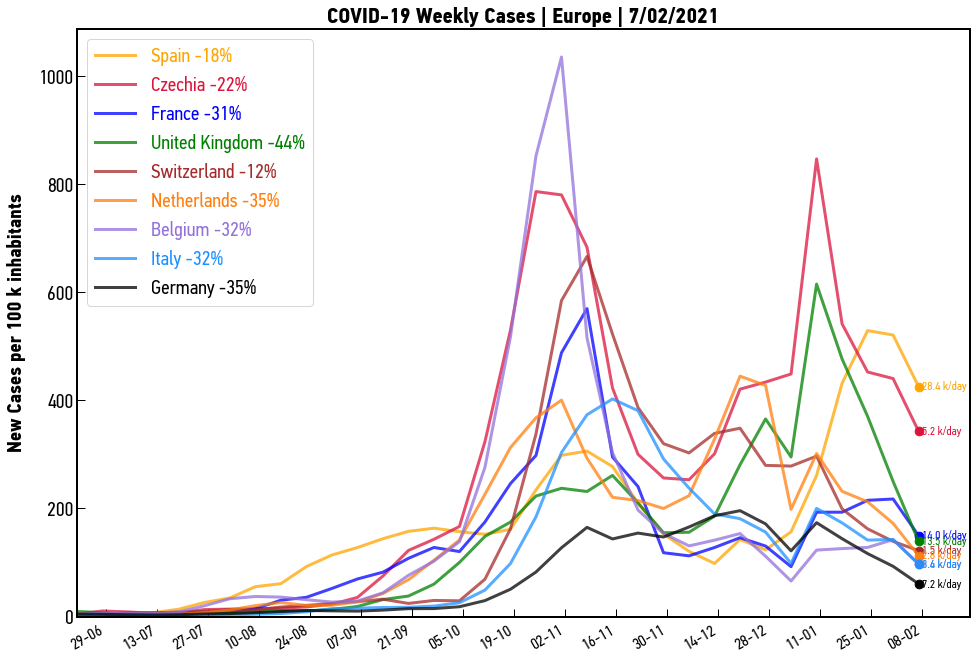

In [11]:
states = [#'Sweden',
          #'US',
          'Italy',  
          'United Kingdom',
          'Spain',
          'Germany', 
          'France', 
          'Belgium',
          'Czechia',
          'Netherlands',
          #'Hungary',
          #'Slovakia',
          #'Romania',
          #'Russia',
          'Switzerland'
         ]


fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111)


states = sorted_states_weekly(states,'new_cases_per100k')
for reg in states:
    df=data_weekly[data_weekly.region==reg]
    dates = df.date[1:-1]
    df_daily = data[(data.region==reg) & (data.date.isin(dates))]
    
    tot = df_daily.cases.iat[-1]
    tot_100k = df_daily.cases_per100k.iat[-1]
    if df.new_cases.iat[-3]>0:
        speed = (df.new_cases.iat[-2] - df.new_cases.iat[-3])/df.new_cases.iat[-3]*100
    else:
        speed = 0
    tot_deaths = df_daily.deaths.iat[-1]
    mortality = tot_deaths/tot*100
    lb = reg
    lb = lb + ' %+.0f%s' % (((df.new_cases.iat[-2]-df.new_cases.iat[-3])/df.new_cases.iat[-3]*100),'%')
    #lb = lb + '\nCASES: %.1f k (1 over %.0f)' % (tot/1e3, 1e5/tot_100k)
    #lb = lb + '\nNew cases (last week): +%d' % (df.new_cases.iat[-2])
    #lb = lb + '\nSpeed: %+.1f%s' % (speed, '%')
    #lb = lb + '\nDEATHS: %.1f k' % (tot_deaths/1e3)
    #lb = lb + '\nMortality: %.1f%s' % (mortality, '%')
    
    ax.plot(df.date[1:-1],df.new_cases_per100k[1:-1], label=lb, color=color[reg], alpha=0.75)
    ax.scatter(df.date.iat[-2],df.new_cases_per100k.iat[-2], label='', color=color[reg], marker='o', s=75)
    #for i in np.arange(-30,-2):
        #ax.scatter(df.date.iat[i],df.new_cases_per100k.iat[i], label='', color='white', marker='o', s=15, zorder=200)

    ax.text(df.date.iat[-2]+timedelta(days=1),df.new_cases_per100k.iat[-2],'%.1f k/day ' % (df.new_cases.iat[-2]/7/1000), color=color[reg], 
            va='center', ha='left', fontsize=12)

    
    
ax.set_ylabel('New Cases per 100 k inhabitants')  
ax.set_xlim(dates.iat[0]+timedelta(days=140), dates.iat[-1]+timedelta(days=14))
ax.set_ylim(0)

leg = ax.legend(loc=0)
leglabels_style()

        
        
ax.xaxis.set_major_locator(mdates.DayLocator(interval=14))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
ax.tick_params(axis='x', which='major', labelsize=16)

fig.autofmt_xdate()
plt.gcf().autofmt_xdate()

plt.title('COVID-19 Weekly Cases | Europe | %s' % lastday_weekly.strftime('%-d/%m/%Y'), fontsize=22)

plt.show()

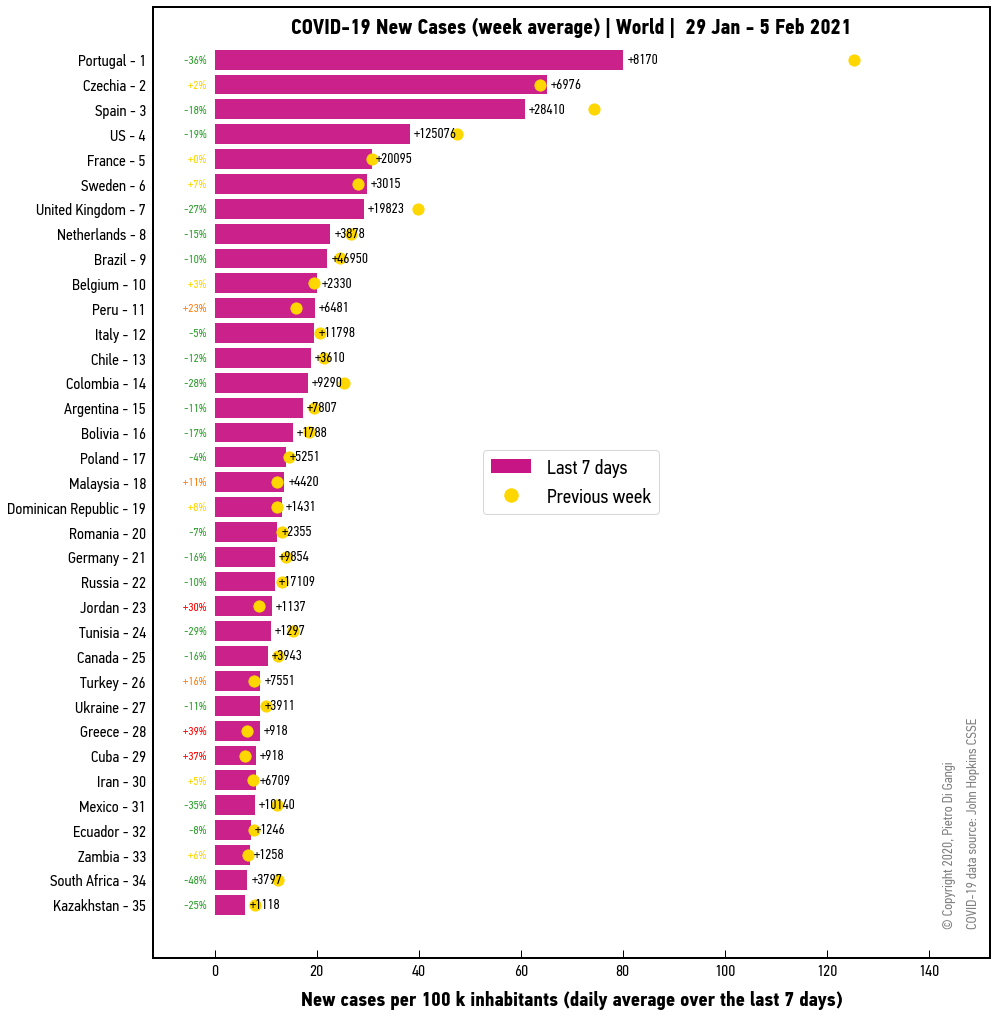

In [12]:
pre_states = data[(data.population>10e6)].region.unique()
states = data_weekly[(data_weekly.date==lastday_weekly)].sort_values('new_cases_per100k', ascending=False).head(200).region.unique()
states = [state for state in states if state in pre_states] 
states = states[:35]
standing_lastweek(states, 'COVID-19 New Cases (week average) | World |  ')

In [13]:
data_weekly[(data_weekly.population>50e6)&(data_weekly.date==lastday_weekly)].sort_values('new_cases_per100k', ascending=False).head(30)

,region,weekid,cases,new_cases,diff_new_cases,deaths,new_deaths,recovered,new_recovered,population,cases_per100k,new_cases_per100k,deaths_per100k,new_deaths_per100k,recovered_per100k,new_recovered_per100k,cases_delta1,cases_delta2,cases_delta3,cases_delta4,deaths_delta1,deaths_delta2,deaths_delta3,deaths_delta4,recovered_delta1,recovered_delta2,recovered_delta3,recovered_delta4,date
13102,Spain,202105,14413554,198871,-44688.0,301444,3067,751880,0,233773915,30827.977535,425.348996,644.734037,6.559757,1608.134937,0.000000,0.070619,0.065717,0.060620,0.058824,0.051529,0.046726,0.042740,0.040604,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2021-02-07
10918,Portugal,202105,3703758,35258,-49068.0,66253,1258,2808724,58865,50983535,36323.079598,345.778299,649.748983,12.337316,27545.402648,577.294219,0.048011,0.050073,0.053133,0.056375,0.096959,0.099830,0.103347,0.106483,1.072206e-01,1.045771e-01,1.065795e-01,1.081646e-01,2021-02-07
3414,Czechia,202105,5020329,36703,-10454.0,83422,668,4465835,37388,53544910,46879.610032,342.730990,778.990944,6.237754,41701.769599,349.127489,0.036743,0.034804,0.033704,0.032924,0.040312,0.038846,0.038383,0.038074,4.217880e-02,4.482384e-02,4.300548e-02,4.206110e-02,2021-02-07
13382,Sweden,202105,2897215,21105,1314.0,59488,524,0,0,50496350,28687.370473,208.975500,589.032673,5.188494,0.000000,0.000000,0.036757,0.033860,0.030738,0.028371,0.044508,0.040892,0.037201,0.034273,5.000000e-10,5.000000e-10,5.000000e-10,5.000000e-10,2021-02-07
14278,US,202105,132802245,621547,-417343.0,2256321,18079,0,0,1635000000,40612.307339,190.075535,690.006422,5.528746,0.000000,0.000000,0.023513,0.023258,0.023453,0.024014,0.040322,0.038499,0.036217,0.034967,5.000000e-10,5.000000e-10,5.000000e-10,5.000000e-10,2021-02-07
4422,France,202105,16166200,97731,-44265.0,385605,2538,1016332,6892,326367560,24766.861020,149.725359,590.752647,3.888254,1557.035877,10.558647,0.030366,0.026387,0.027637,0.029964,0.033147,0.027923,0.027263,0.029696,3.411546e-02,2.786986e-02,2.694434e-02,2.785301e-02,2021-02-07
14502,United Kingdom,202105,19364263,94397,-75316.0,545426,5106,0,0,339430020,28524.676456,139.052226,803.443962,7.521433,0.000000,0.000000,0.024489,0.024811,0.025198,0.026088,0.047227,0.045409,0.045845,0.046022,5.000000e-10,5.000000e-10,5.000000e-10,5.000000e-10,2021-02-07
1790,Brazil,202105,46695618,242434,-117720.0,1137800,5530,41534654,219775,1062797045,21968.266763,114.054702,535.285643,2.601626,19540.256625,103.394623,0.026069,0.024874,0.024583,0.024581,0.024396,0.022936,0.022560,0.022249,2.660117e-02,2.651096e-02,2.769390e-02,2.938501e-02,2021-02-07
9518,Netherlands,202105,4947305,19276,-10266.0,70830,296,0,0,85674365,28872.726398,112.495727,413.367522,1.727471,0.000000,0.000000,0.019547,0.019270,0.019198,0.019269,0.020973,0.020263,0.020587,0.020682,5.000000e-10,5.000000e-10,5.000000e-10,5.000000e-10,2021-02-07
1286,Belgium,202105,3581362,11279,-5208.0,106068,203,0,0,57948080,30901.472491,97.319877,915.198571,1.751568,0.000000,0.000000,0.015785,0.015622,0.015712,0.015617,0.009588,0.009382,0.009383,0.009305,5.000000e-10,5.000000e-10,5.000000e-10,5.000000e-10,2021-02-07


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


ValueError: x and y must have same first dimension, but have shapes (54,) and (53,)

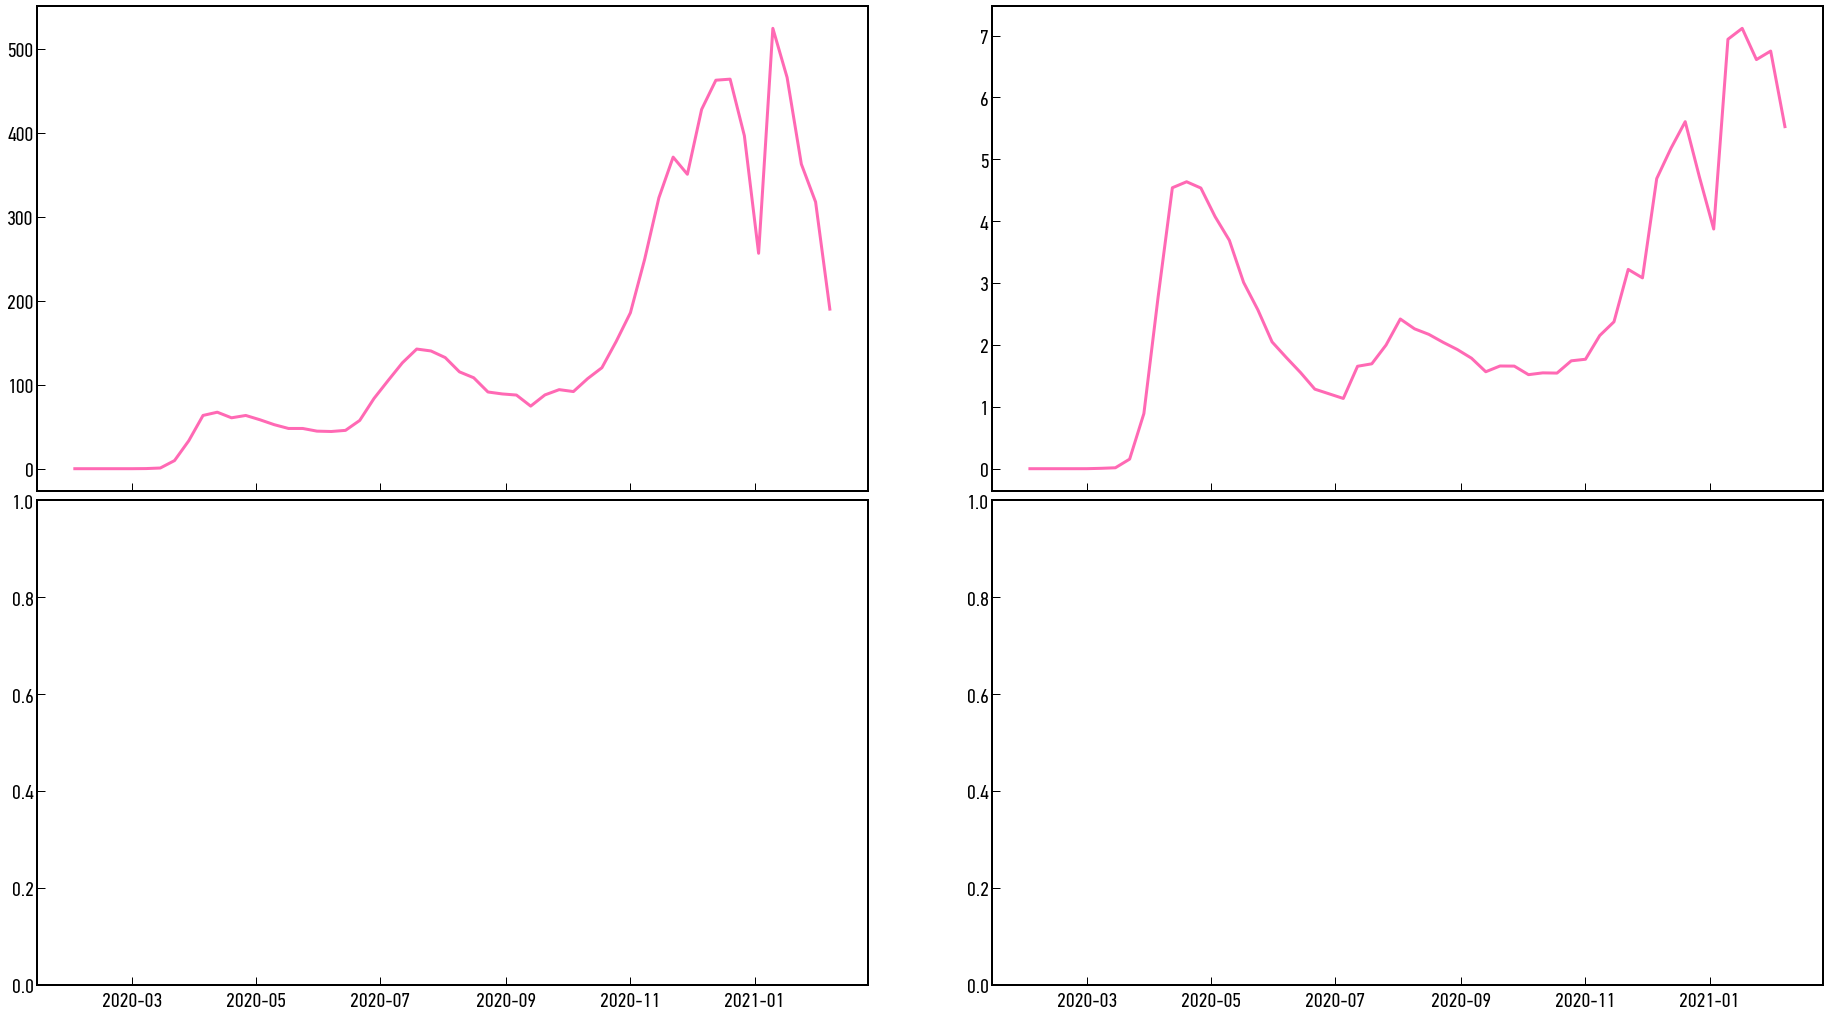

In [14]:
states = ['Sweden',
          'Brazil',
          'Russia',
          'Italy', 
          'Spain', 
          'United Kingdom', 
          'Germany', 
          'France', 
          'US', 
          'Korea, South',
          'Hubei',
          #'Iran',
          'Japan',
          #'Australia',
          'Belgium',
          #'Canada',
          #'India',
          'South Africa',
          'Chile'
         ]


fig = plt.figure(figsize=(32,18))

grid = plt.GridSpec(2, 2, hspace=0.02, wspace=0.15)
ax = fig.add_subplot(grid[0, 0])
ax2 = fig.add_subplot(grid[1, 0], sharex=ax)
ax3 = fig.add_subplot(grid[0, 1])
ax4 = fig.add_subplot(grid[1, 1], sharex=ax3)


states = sorted_states_weekly(states,'cases_per100k')
for reg in states:
    df=data_weekly[data_weekly.region==reg]
    dates = df.date[1:-1]
    df_daily = data[(data.region==reg) & (data.date.isin(dates))]
    
    tot = df_daily.cases.iat[-1]
    tot_100k = df_daily.cases_per100k.iat[-1]
    if df.new_cases.iat[-3]>0:
        speed = (df.new_cases.iat[-2] - df.new_cases.iat[-3])/df.new_cases.iat[-3]*100
    else:
        speed = 0
    tot_deaths = df_daily.deaths.iat[-1]
    mortality = tot_deaths/tot*100
    lb = reg
    lb = lb + '\nCASES: %.1f k (1 over %.0f)' % (tot/1e3, 1e5/tot_100k)
    lb = lb + '\nSpeed: %+.1f%s' % (speed, '%')
    lb = lb + '\nDEATHS: %.1f k' % (tot_deaths/1e3)
    lb = lb + '\nMortality: %.1f%s' % (mortality, '%')
    
    ax.plot(df.date[1:-1],df.new_cases_per100k[1:-1], label=lb, color=color[reg])
    ax3.plot(df.date[1:-1],df.new_deaths_per100k[1:-1], label=lb, color=color[reg])
    ax2.plot(dates,df_daily.cases_per100k, label=lb, color=color[reg])
    ax4.plot(dates,df_daily.deaths_per100k, label='', color=color[reg])
    
    
  
ax.set_xlim(dates.iat[4], dates.iat[-1]+timedelta(days=15))
ax3.set_xlim(dates.iat[4], dates.iat[-1]+timedelta(days=15))

leg = ax.legend(ncol=5, loc='upper left', bbox_to_anchor=(0,1.85), fontsize=18, frameon=False)
leglabels_style()


'''
for axx in [ax,ax2,ax3,ax4]:
    axx.autoscale(False) 
    locs = axx.get_yticks()
    for y in [i for i in locs[1:-1] if i > 0]:
        axx.hlines(y,datetime.date(2019,1,1),datetime.date(2021,1,1), color='k', linestyles=':', alpha=0.05)
        t = axx.text(dates.iat[-1]+timedelta(days=14), y, '1:%.0f' % (1./y*1e5), ha='right', va='center', color='silver')
        t.set_bbox(dict(facecolor='w', alpha=1, edgecolor='w'))
'''

ax.text(0.05, .92, 'WEEKLY CASES', fontsize=22, weight='bold', ha='left', va='top', transform=ax.transAxes)
ax.set_ylabel('New cases per 100k inhabitants')
ax2.text(0.05, .92, 'CUMULATIVE CASES', fontsize=22, weight='bold', ha='left', va='top', transform=ax2.transAxes)
ax2.set_ylabel('Total cases per 100k inhabitants')
ax3.text(0.05, .92, 'WEEKLY DEATHS', fontsize=22, weight='bold', ha='left', va='top', transform=ax3.transAxes)
ax3.set_ylabel('New deaths per 100k inhabitants')
ax4.text(0.05, .92, 'CUMULATIVE DEATHS', fontsize=22, weight='bold', ha='left', va='top', transform=ax4.transAxes)
ax4.set_ylabel('Total deaths per 100k inhabitants')
        
        
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
ax.tick_params(axis='x', which='major', labelsize=16)
ax3.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
ax3.tick_params(axis='x', which='major', labelsize=16)



fig.autofmt_xdate()
plt.gcf().autofmt_xdate()


plt.suptitle('COVID-19 Weekly Data | Cases and Deaths (%s)' % lastday_weekly.strftime('%-d/%m/%Y'), fontsize=28, y=1.2)


plt.show()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


ValueError: x and y must have same first dimension, but have shapes (54,) and (53,)

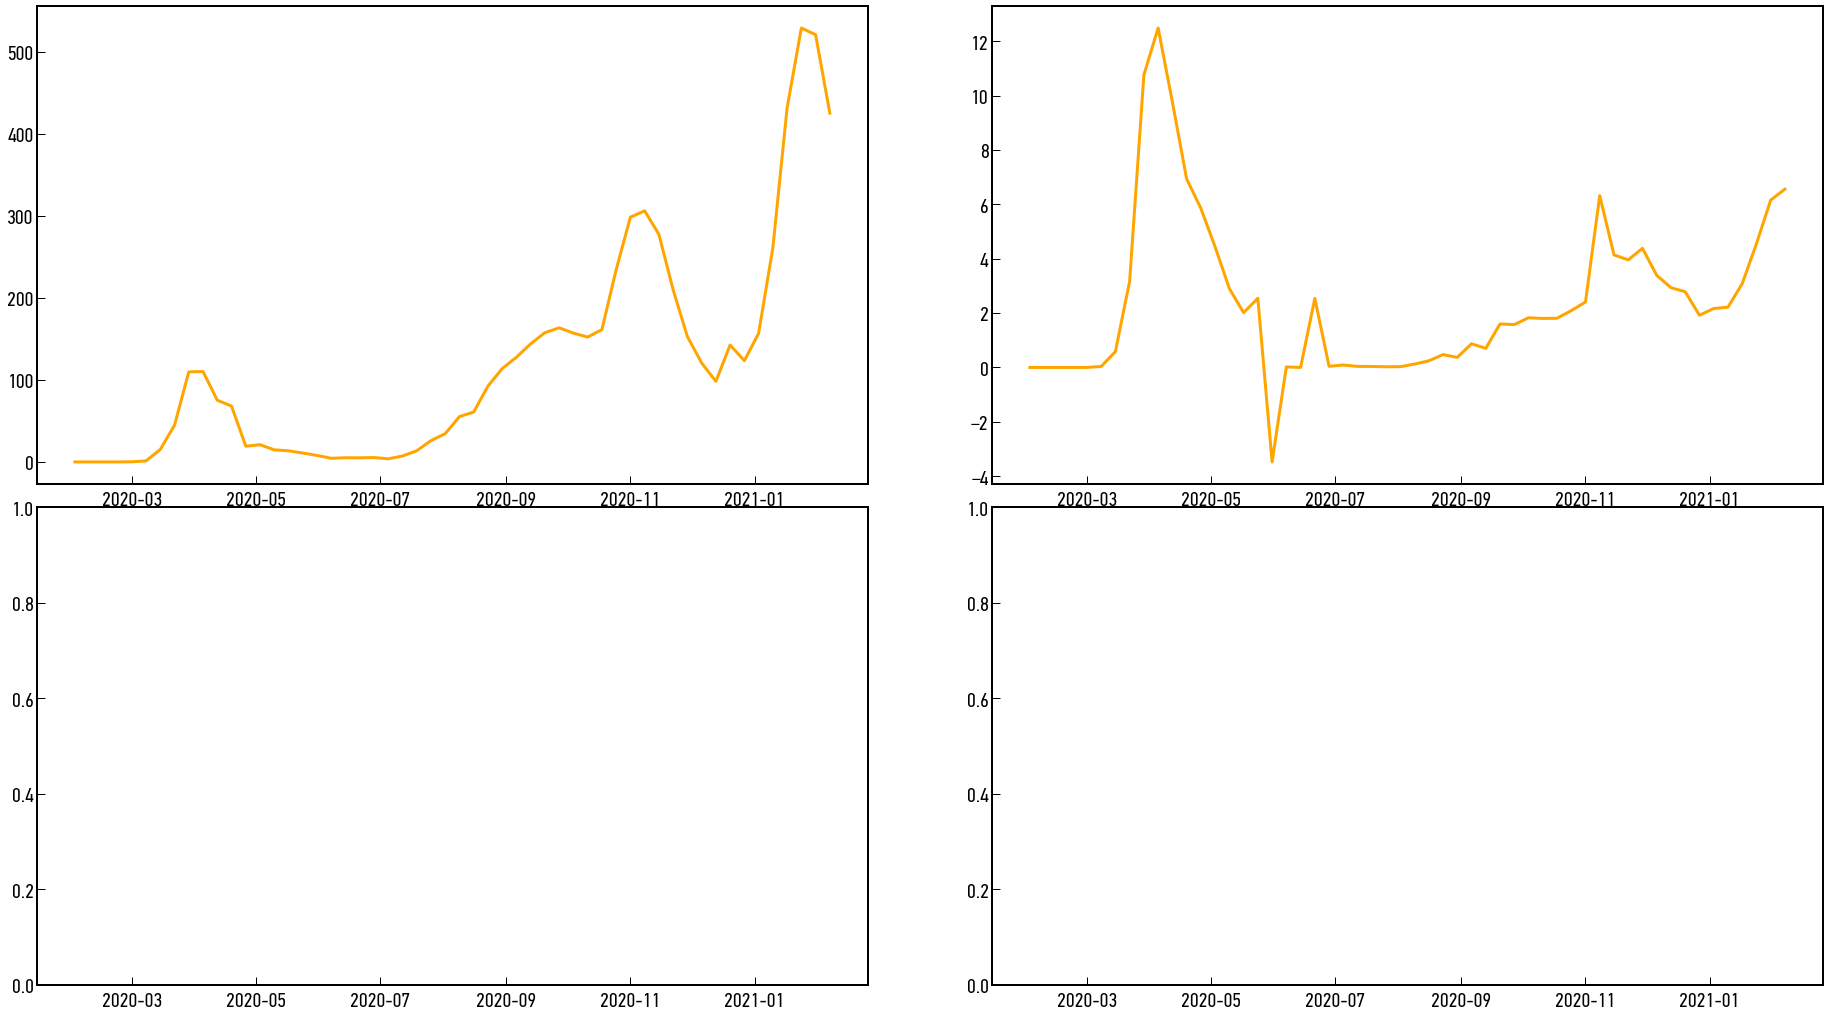

In [16]:
states = [#'Sweden',
          #'Brazil',
          #'US',
          'Italy',  
          'United Kingdom',
          'Spain',
          'Germany', 
          'France', 
          #'Korea, South',
          #'Hubei',
          #'Iran',
          #'Japan',
          #'Australia',
          #'Belgium',
          #'Canada',
          #'India',
          #'South Africa',
          #'Chile'
         ]


fig = plt.figure(figsize=(32,18))

grid = plt.GridSpec(2, 2, hspace=0.05, wspace=0.15)
ax = fig.add_subplot(grid[0, 0])
ax2 = fig.add_subplot(grid[1, 0], sharex=ax)
ax3 = fig.add_subplot(grid[0, 1])
ax4 = fig.add_subplot(grid[1, 1], sharex=ax3)


states = sorted_states_weekly(states,'cases_per100k')
for reg in states:
    df=data_weekly[data_weekly.region==reg]
    dates = df.date[1:-1]
    df_daily = data[(data.region==reg) & (data.date.isin(dates))]
    
    tot = df_daily.cases.iat[-1]
    tot_100k = df_daily.cases_per100k.iat[-1]
    if df.new_cases.iat[-3]>0:
        speed = (df.new_cases.iat[-2] - df.new_cases.iat[-3])/df.new_cases.iat[-3]*100
    else:
        speed = 0
    tot_deaths = df_daily.deaths.iat[-1]
    mortality = tot_deaths/tot*100
    lb = reg
    lb = lb + '\nCASES: %.1f k (1 over %.0f)' % (tot/1e3, 1e5/tot_100k)
    lb = lb + '\nNew cases (last week): +%d' % (df.new_cases.iat[-2])
    lb = lb + '\nSpeed: %+.1f%s' % (speed, '%')
    lb = lb + '\nDEATHS: %.1f k' % (tot_deaths/1e3)
    lb = lb + '\nMortality: %.1f%s' % (mortality, '%')
    
    ax.plot(df.date[1:-1],df.new_cases_per100k[1:-1], label=lb, color=color[reg])
    ax3.plot(df.date[1:-1],df.new_deaths_per100k[1:-1], label=lb, color=color[reg])
    ax2.plot(dates,df_daily.cases_per100k, label=lb, color=color[reg])
    ax4.plot(dates,df_daily.deaths_per100k, label='', color=color[reg])
    
    
  
ax.set_xlim(dates.iat[0]+timedelta(days=30), dates.iat[-1]+timedelta(days=15))
ax3.set_xlim(dates.iat[0]+timedelta(days=30), dates.iat[-1]+timedelta(days=15))

leg = ax.legend(ncol=5, loc='upper left', bbox_to_anchor=(-0.1,1.4), fontsize=18, frameon=False)
leglabels_style()



for axx in [ax,ax2,ax3,ax4]:
    axx.autoscale(False) 
    locs = axx.get_yticks()
    for y in [i for i in locs[1:-1] if i >= 0]:
        axx.hlines(y,datetime.date(2019,1,1),datetime.date(2021,1,1), color='k', linestyles=':', alpha=0.05)
        #t = axx.text(dates.iat[-1]+timedelta(days=14), y, '1:%.0f' % (1./y*1e5), ha='right', va='center', color='silver')
        #t.set_bbox(dict(facecolor='w', alpha=1, edgecolor='w'))

ax.text(0.05, .92, 'WEEKLY CASES', fontsize=22, weight='bold', ha='left', va='top', transform=ax.transAxes)
ax.set_ylabel('New cases per 100k inhabitants')
ax2.text(0.05, .92, 'CUMULATIVE CASES', fontsize=22, weight='bold', ha='left', va='top', transform=ax2.transAxes)
ax2.set_ylabel('Total cases per 100k inhabitants')
ax3.text(0.05, .92, 'WEEKLY DEATHS', fontsize=22, weight='bold', ha='left', va='top', transform=ax3.transAxes)
ax3.set_ylabel('New deaths per 100k inhabitants')
ax4.text(0.05, .92, 'CUMULATIVE DEATHS', fontsize=22, weight='bold', ha='left', va='top', transform=ax4.transAxes)
ax4.set_ylabel('Total deaths per 100k inhabitants')
        
        
ax.xaxis.set_major_locator(mdates.DayLocator(interval=14))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
ax.tick_params(axis='x', which='major', labelsize=16)
ax3.xaxis.set_major_locator(mdates.DayLocator(interval=14))
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
ax3.tick_params(axis='x', which='major', labelsize=16)



fig.autofmt_xdate()
plt.gcf().autofmt_xdate()


plt.suptitle('COVID-19 Weekly Data | Cases and Deaths (%s)' % lastday_weekly.strftime('%-d/%m/%Y'), fontsize=28, y=1.05)


plt.show()

In [19]:
def guideline(ax, xlim=(0,1), ylim=(0,1), m=1, label=''):
    xmin = xlim[0]
    xmax = xlim[1]
    ymin = ylim[0]
    ymax = ylim[1]
    ax.plot((0,xmax), (0,m*xmax), ls='--', lw=1, color='silver', zorder=-100)

    mplot = (ymax-ymin)/(xmax-xmin)
    if m < mplot:
        coord = [0.85*xmax, 0.85*xmax*m]
    else:
        coord = [0.85*ymax/m, 0.85*ymax]
    label = '%.f%s ' % (m*100, '%') + label
    ax.text(coord[0], coord[1], label, color='silver', fontsize=12, rotation=np.rad2deg(np.arctan(m/mplot)), ha='center', va='center', backgroundcolor='w', zorder=-100)

def trailplot(regions, ndays, varx, vary, xlabel, ylabel, xlim, ylim, guidelines, gl_label):
    #sorted_df = data[data.region.isin(regions)][data.date==lastday].sort_values(varx)
    #regions = sorted_df.region.unique()

    # Set up the axes with gridspec
    fig = plt.figure(figsize=(14,14))
    grid = plt.GridSpec(4, 4, hspace=0., wspace=0.)
    ax = fig.add_subplot(grid[:-1, 1:])
    y_ax = fig.add_subplot(grid[:-1, 0], xticks=[], sharey=ax)
    x_ax = fig.add_subplot(grid[-1, 1:], sharex=ax)
    x_ax.tick_params(axis='y', which='major', labelsize=14)
    ax.tick_params(labelbottom=False, labelleft=False)



    # plot curves
    days = np.arange(1,ndays)
    mk = 'o'
    ms=200
    #dummy points
    #x_ax.scatter(0,'',label='', color='w', marker=mk, s=ms)
    y_ax.scatter('',0,label='', color='w', marker=mk, s=ms)

    for i,reg in enumerate(regions):
        df = data[data.region==reg]
        pop = df['population'].iat[0]
        #ax.scatter(df[varx].iat[-1]/pop*1e5, df[vary].iat[-1]/pop*1e5, label='', color=color, marker=mk, s=ms)
        #x_ax.scatter(x,state,label='', color=color, marker=mk, s=ms, alpha=alpha)
        #y_ax.scatter(state,y,label='', color=color, marker=mk, s=ms, alpha=alpha)
        for day in list(reversed(days)):
            x = df[varx].iat[-day]/pop*1e5 # total value 'day' ago
            y = df[vary].iat[-day]/pop*1e5
            alpha = 1./day
            ax.scatter(x,y,label='', color=color[reg], marker=mk, s=ms, alpha=alpha)
            x_ax.scatter(x,reg,label='', color=color[reg], marker=mk, s=ms, alpha=alpha)
            y_ax.scatter(reg,y,label='', color=color[reg], marker=mk, s=ms, alpha=alpha)
        #x_ax.text(x+0.03*xlim[1], reg, '%d (+%d)' % (df[varx].iat[-1], df['new_'+varx].iat[-1]), ha='left', va='center', fontsize=11)
        #y_ax.text(reg, y+0.03*ylim[1], '%d (+%d)' % (df[vary].iat[-1], df['new_'+vary].iat[-1]), ha='center', va='bottom', fontsize=11, rotation=90)

    # axes
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    x_ax.set_xlim(xlim)
    y_ax.set_ylim(ylim)
    y_ax.set_ylabel(ylabel+' per 100 000 inhabitants')
    x_ax.set_xlabel(xlabel+' per 100 000 inhabitants')

    # mortality guidelines
    for m in guidelines:
        guideline(ax=ax, xlim=xlim, ylim=ylim, m=m, label=gl_label)

    #legend
    #leg = ax.legend(loc=0, frameon=True, ncol=1, 
    ax.set_title('COVID-19 | Last %d days (Updated %s)' % (ndays, lastday.strftime('%-d %b %Y')))
    #leglabels_style()

    plt.show()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


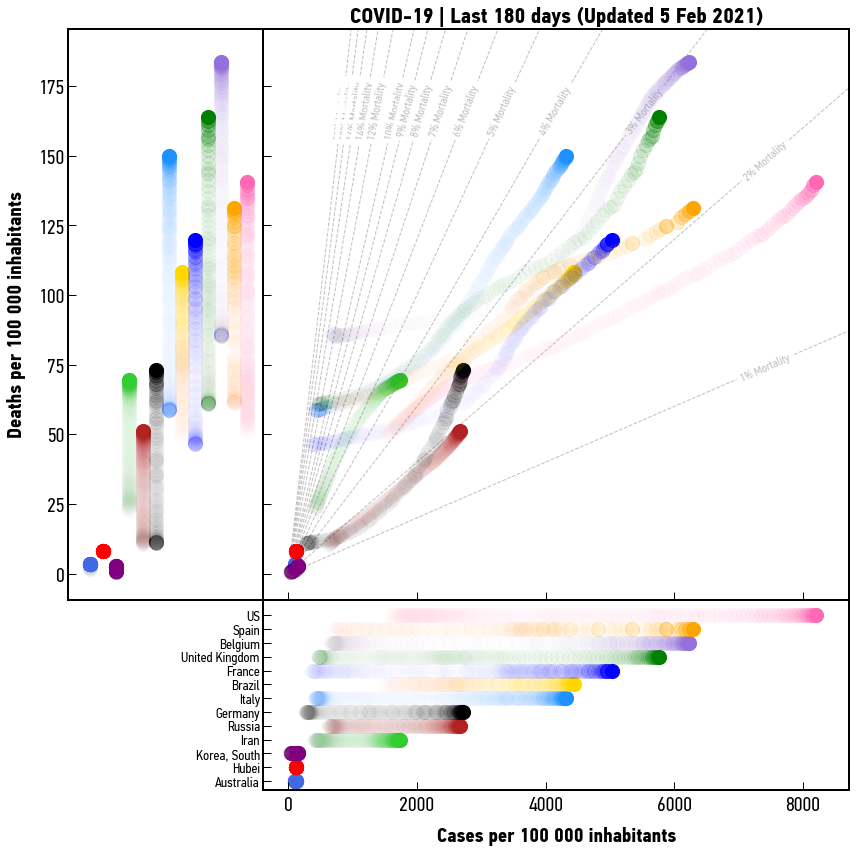

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


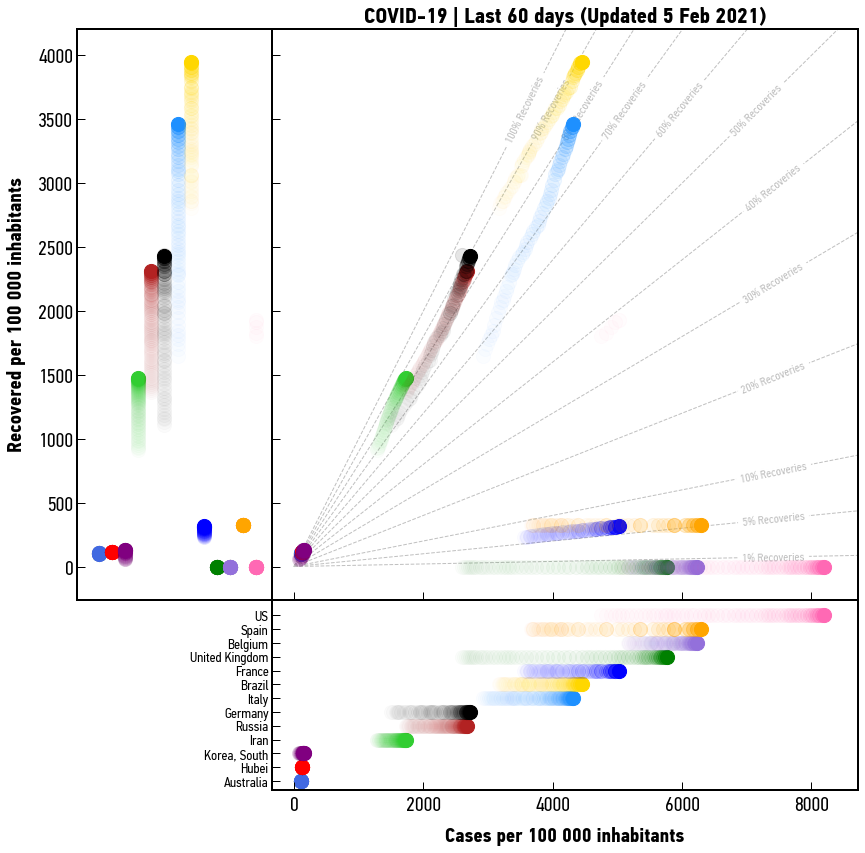

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


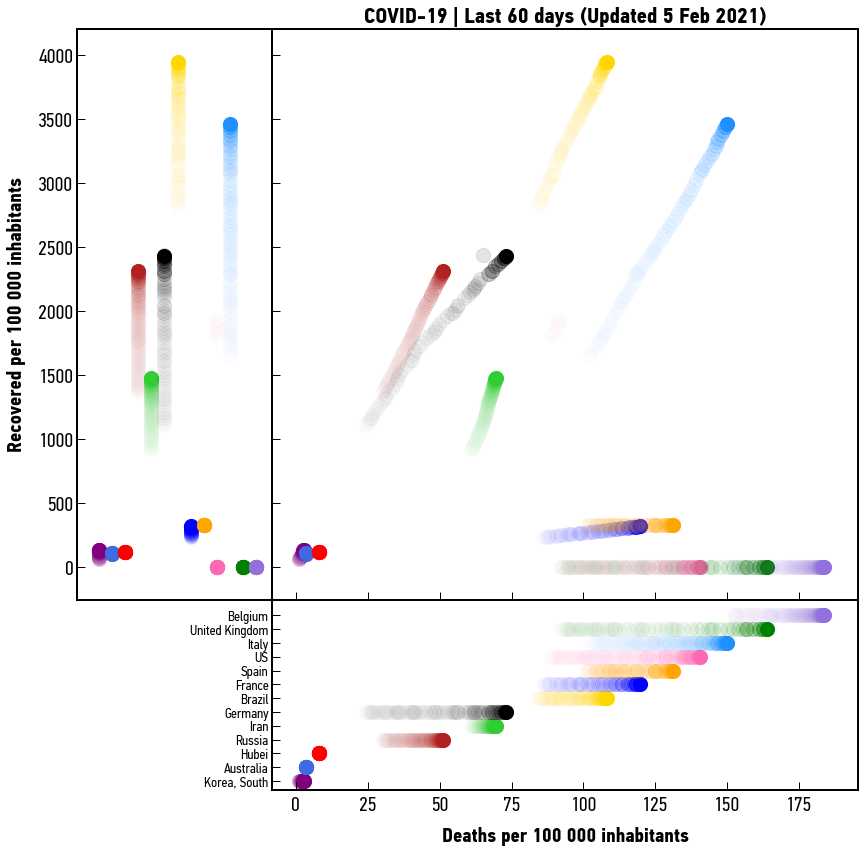

In [20]:
# Cases vs Deaths
states = ['Belgium','Brazil','Russia','Italy', 'Spain', 'United Kingdom', 'Germany', 'France', 'Hubei', 'US', 'Korea, South', 'Australia', 'Iran']
states = data[data.region.isin(states)][data.date==lastday].sort_values('cases_per100k').region.unique()
#print(states)
trailplot(regions=states, ndays=180,
          varx='cases', vary='deaths', xlabel='Cases', ylabel='Deaths',
          xlim=(-15,380), ylim=(-1,40), guidelines=[0.2,0.18,0.16,0.14,0.12,0.1,0.09,0.08,0.07,0.06,0.05,0.03,0.04,0.02,0.01], gl_label='Mortality',
         )

# Cases vs Recovered
states = data[data.region.isin(states)][data.date==lastday].sort_values('cases_per100k').region.unique()
trailplot(regions=states, ndays=60,
          varx='cases', vary='recovered', xlabel='Cases', ylabel='Recovered',
          xlim=(-15,380), ylim=(-3,119), guidelines=[1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.05,0.01,], gl_label='Recoveries',
         )

# Deaths vs Recovered
states = data[data.region.isin(states)][data.date==lastday].sort_values('deaths_per100k').region.unique()
trailplot(regions=states, ndays=60,
          varx='deaths', vary='recovered', xlabel='Deaths', ylabel='Recovered',
          xlim=(-1,40), ylim=(-3,119), guidelines=[], gl_label='',
         )

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


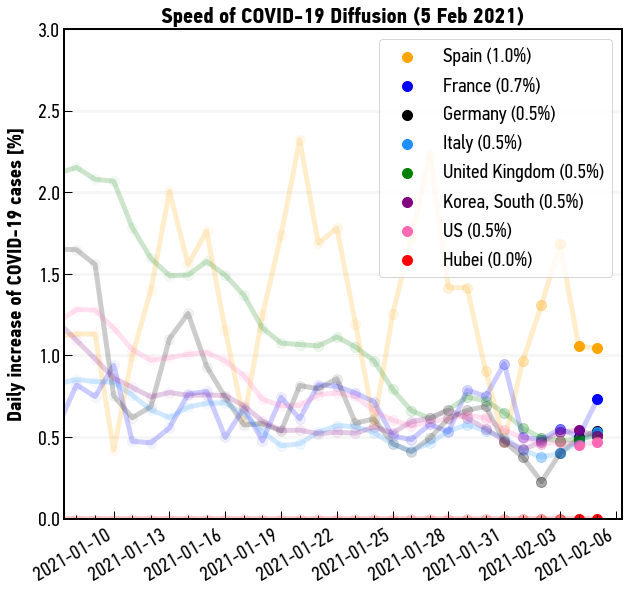

In [21]:
var = 'cases_delta3'
states = ['Italy', 'Spain', 'United Kingdom', 'Germany', 'France', 'Hubei', 'US', 'Korea, South']
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

#lockdown lines
#lockdown_lines()

# sort by most cases
states = sorted_states(states, var)

# plot curves
for state in states:
    df = data[data.region==state]    
    ax.plot(df.date, df[var]*100, label='', color=color[state], lw=5, alpha=0.2)

ndays = 30
days = np.arange(1,ndays) 
mk='o'
ms=100
for state in states:
    df = data[data.region==state]
    tot = df[var].iat[-1]*100 # total value at current date
    pop = df.population.iat[0]
    label = state + ' (%.1f%s)' % (tot,'%')
    ax.scatter(df.date.iat[-1], df[var].iat[-1]*100, label=label, color=color[state], marker=mk, s=ms)
    for day in list(reversed(days)):
        x = df['date'].iat[-1-day] # total value 'day' ago
        y = df[var].iat[-1-day]*100
        alpha = 1/day
        ax.scatter(x,y,label='', color=color[state], marker=mk, s=ms, alpha=alpha)

# axes
format_dateaxis()
ax.set_xlim([today-timedelta(days=ndays), today+timedelta(days=0)])
ax.set_ylim(0,3)
plt.ylabel('Daily increase of COVID-19 cases [%]')
#plt.xscale('log')
plt.grid(axis='y', linewidth=3, alpha=0.1, which='both')

#legend
leg = plt.legend(loc=0, frameon=True)
plt.title('Speed of COVID-19 Diffusion (%s)' % lastday.strftime('%-d %b %Y'))
leglabels_style()

plt.show()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


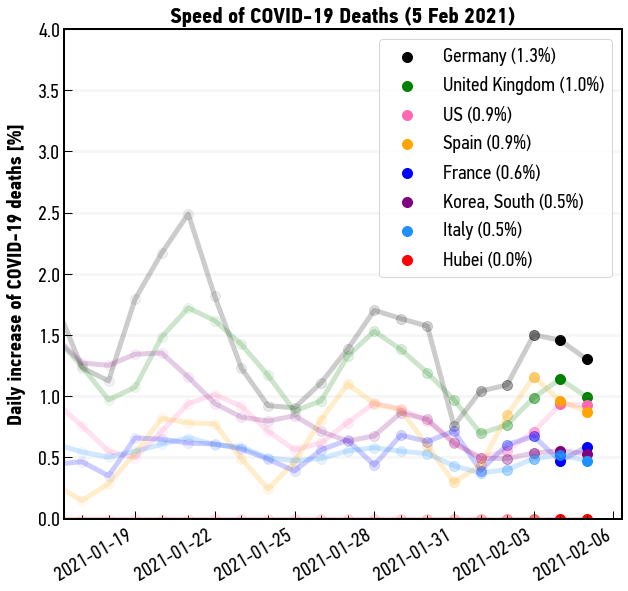

In [22]:
var = 'deaths_delta3'
states = ['Italy', 'Spain', 'United Kingdom', 'Germany', 'France', 'Hubei', 'US', 'Korea, South']
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

#lockdown lines
#lockdown_lines()

# sort by most cases
states = sorted_states(states, var)

# plot curves
for state in states:
    df = data[data.region==state]    
    ax.plot(df.date, df[var]*100, label='', color=color[state], lw=5, alpha=0.2)

ndays = 21
days = np.arange(1,ndays) 
mk='o'
ms=100
for state in states:
    df = data[data.region==state]
    tot = df[var].iat[-1]*100 # total value at current date
    df.population.iat[0]
    label = state + ' (%.1f%s)' % (tot,'%')
    ax.scatter(df.date.iat[-1], df[var].iat[-1]*100, label=label, color=color[state], marker=mk, s=ms)
    for day in list(reversed(days)):
        x = df['date'].iat[-1-day] # total value 'day' ago
        y = df[var].iat[-1-day]*100
        alpha = 1/day
        ax.scatter(x,y,label='', color=color[state], marker=mk, s=ms, alpha=alpha)

# axes
format_dateaxis()
ax.set_xlim([today-timedelta(days=ndays), today+timedelta(days=0)])
ax.set_ylim(0,4)
plt.ylabel('Daily increase of COVID-19 deaths [%]')
plt.grid(axis='y', linewidth=3, alpha=0.1, which='both')

#legend
leg = plt.legend(loc=0, frameon=True)
plt.title('Speed of COVID-19 Deaths (%s)' % lastday.strftime('%-d %b %Y'))
leglabels_style()

plt.show()